In [28]:
import numpy as np
import os
import sys 
import pickle
import soundfile as sf
import librosa
from pathlib import Path
import random
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import glob

# append echo encoding parent dir to path
curr_dir = os.getcwd()
echo_dir = curr_dir.split("EchoDARENet")[0] 
sys.path.append(echo_dir)
from traditional_echo_hiding import encode, create_filter_bank, decode


In [29]:
# load a librispeech sample
speech_path = "/media/storage/hadleigh/reverb_speech_data/hi_fi_tts_v0/audio/92_clean/6973/livingalone_02_benson_0001.flac"
# "Datasets/LibriSpeech/dev-clean/84/121123/84-121123-0001.flac"

# load an MIT RIR sample
mit_rirs = glob.glob("/media/storage/hadleigh/reverb_speech_data/MIT_IR_Survey/*.wav")
homula_rirs = glob.glob("/media/storage/hadleigh/reverb_speech_data/homula_ir/*.wav")
soundcam_rirs = glob.glob("/media/storage/hadleigh/reverb_speech_data/SoundCamFlat_temp/ConferenceRoom_preprocessed/Empty/*.npy")


## Visualize Effect of IRs at Different SRs on Cepstra

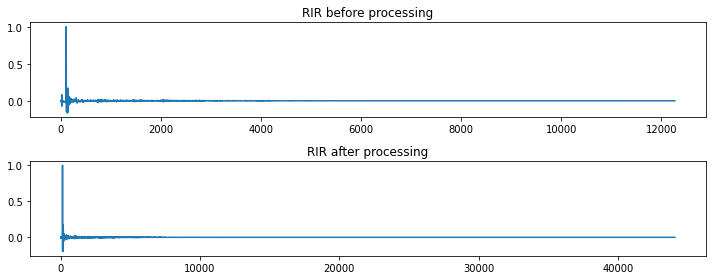

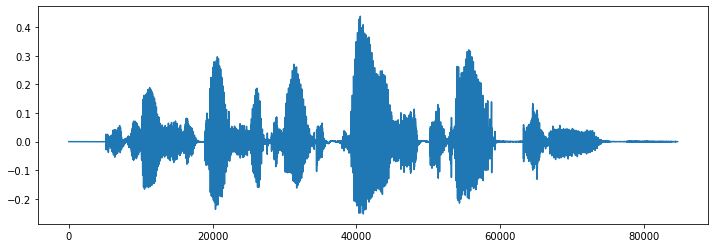

(84672,)


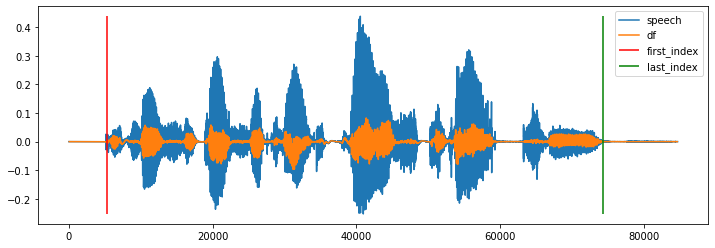

Symbol Error Rate: 0.125


In [30]:

rir_path = mit_rirs[0]

nwins = 32
win_size = 3072
delays = [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]
amplitude = 0.4
kernel =  "bp"
decoding = "cepstrum" # options: "autocepstrum", "cepstrum"
cutoff_freq = 1000
hanning_factor = 4
reverb_speech_duration = nwins * win_size

np.random.seed(18)

def gen_example(TARGET_SR):
    speech, speech_sr = sf.read(speech_path)
    rir, rir_sr = sf.read(rir_path)

    rir_sos = signal.butter(6, 40, 'hp', fs = TARGET_SR, output='sos') # Seems that this is largely for denoising the RIRs??
    rir_length = 1 * TARGET_SR # 1 second RIR

    # if multiple channels, take the first channel
    if len(rir.shape) > 1:
        rir = rir[:, 0]

    rir_before_processing = rir.copy()
    
    rir = rir.flatten()
    rir = rir[~np.isnan(rir)]
    rir = librosa.resample(rir,
        orig_sr=rir_sr,
        target_sr=TARGET_SR,
        res_type='soxr_hq')
    rir = rir - np.mean(rir)
    rir = rir / np.max(np.abs(rir))
    maxI = np.argmax(np.abs(rir))
    rir = rir[25:]
    rir = rir * signal.windows.tukey(rir.shape[0], alpha=2*25/rir.shape[0], sym=True) # Taper 50 samples at the beginning and end of the RIR
    rir = signal.sosfilt(rir_sos, rir) # not sure we want this??
    maxI = np.argmax(np.abs(rir))
    rir = rir / rir[maxI] # scaling
    if len(rir) < rir_length:
        rir = np.pad(rir, pad_width=(0, np.max((0,rir_length - len(rir)))))
    elif len(rir) > rir_length:
        rir = rir[:rir_length]

    # visualize the RIR before and after processing
    fig, axes = plt.subplots(2, 1, figsize=(10, 4))
    axes[0].plot(rir_before_processing)
    axes[0].set_title("RIR before processing")
    axes[1].plot(rir)
    axes[1].set_title("RIR after processing")
    plt.tight_layout()
    plt.show()
    plt.close(0)

    fig = plt.figure(figsize=(12, 4))
    plt.plot(speech)
    plt.show()
    plt.close(0)


    # resample the speech if needed
    speech = librosa.resample(speech,
        orig_sr=speech_sr,
        target_sr=TARGET_SR,
        res_type='soxr_hq')

    print(speech.shape)
    # apply a rolling average to the speech
    speech_pos = speech + -1*np.min(speech)
    df = pd.Series(speech_pos)
    df = df.rolling(100, center=True).median()
    df = df + np.min(speech)
    # find first index in df where it is greater than 0.001
    first_index = df[df > 0.001].index[0]
    # find last index in df where it is greater than 0.001
    last_index = df[df > 0.001].index[-1]
    ymin = np.min(speech)
    ymax = np.max(speech)
    # plot the speech and df
    plt.figure(figsize=(12, 4))
    plt.plot(speech, label='speech')
    plt.plot(df, label='df')
    plt.vlines(first_index, ymin, ymax, color='r', label='first_index')
    plt.vlines(last_index, ymin, ymax, color='g', label='last_index')
    plt.legend()
    plt.show()
    plt.close(0)

    # pad the speech if needed
    speech = np.pad(
            speech,
            pad_width=(0, np.max((0, reverb_speech_duration - len(speech)))),
        )
    num_wins = len(speech) // win_size
    symbols = np.random.randint(0, len(delays), size = num_wins)
    speech = speech[:num_wins * win_size] # trim the speech to be a multiple of the window size. 
    enc_speech = encode(speech, symbols, amplitude, delays, win_size, TARGET_SR, kernel, hanning_factor = hanning_factor)
    
    # convolve the speech with the RIR
    enc_reverb_speech = signal.convolve(enc_speech, rir, mode='full')

    start_options = [i for i in range(0, len(enc_speech) - reverb_speech_duration + win_size, win_size)]
    start = np.random.choice(start_options)
    enc_speech = enc_speech[start:start + reverb_speech_duration]
    enc_reverb_speech = enc_reverb_speech[start:start + reverb_speech_duration]
    start_win = start // win_size
    symbols = symbols[start_win:start_win + reverb_speech_duration // win_size]

    return enc_speech, enc_reverb_speech, symbols
    

# enc_speech_16khz, symbols_16khz = gen_example(16000)
# decoded_symbols_16khz, _ = decode(enc_speech_16khz, delays, win_size, 16000, cutoff_freq = cutoff_freq, plot = True, save_plot_path = None, gt = symbols_16khz)

_, enc_speech_44khz, symbols_44khz = gen_example(44100)
decoded_symbols_44khz, _ = decode(enc_speech_44khz, delays, win_size, 44100, cutoff_freq = cutoff_freq, plot = False, save_plot_path = None, gt = symbols_44khz)

# compute the symbol error rate
ser = np.sum(symbols_44khz != decoded_symbols_44khz[:len(symbols_44khz)]) / len(symbols_44khz)
print(f"Symbol Error Rate: {ser}")  


## Figure out how to best align IRs

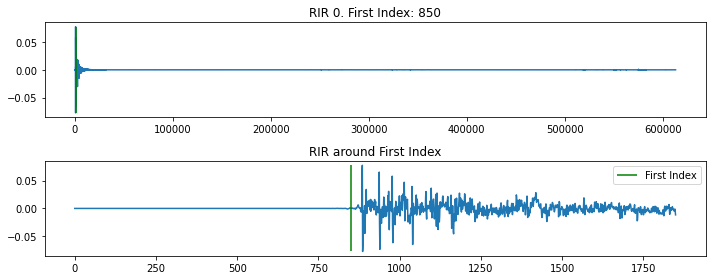

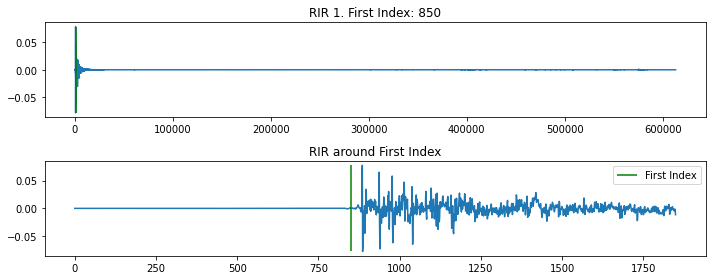

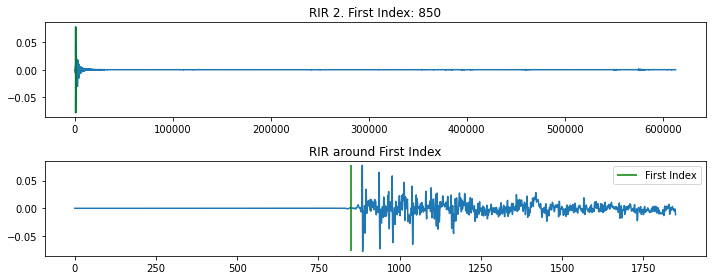

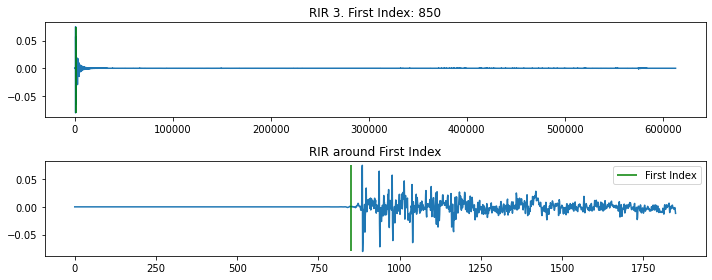

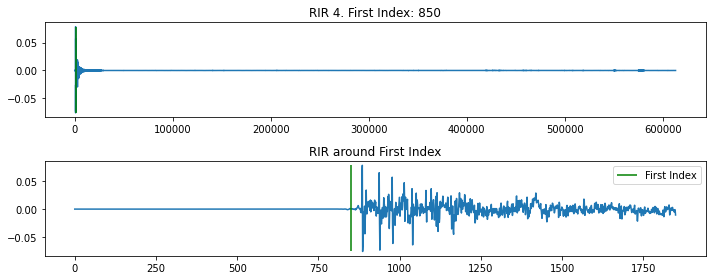

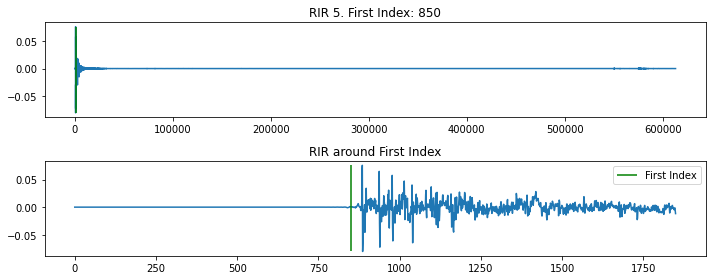

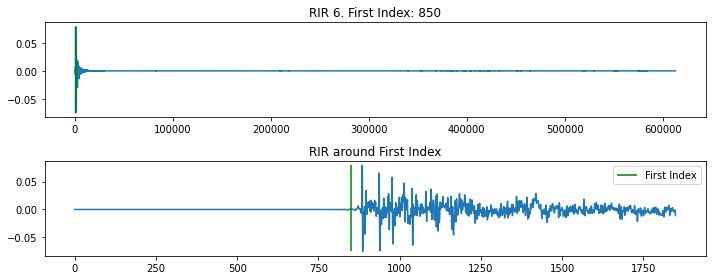

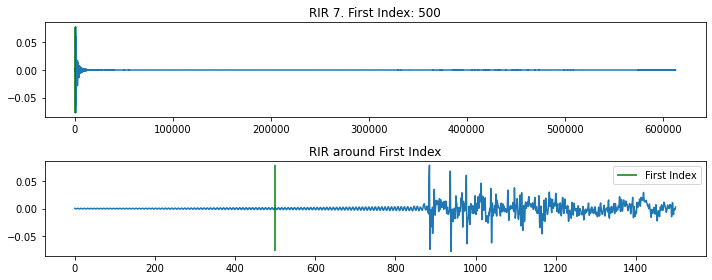

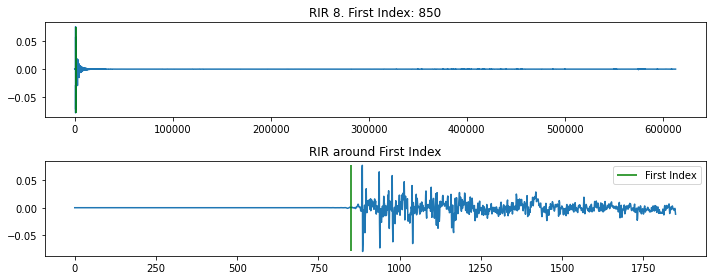

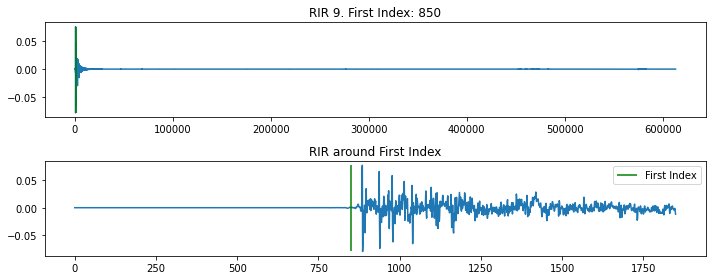

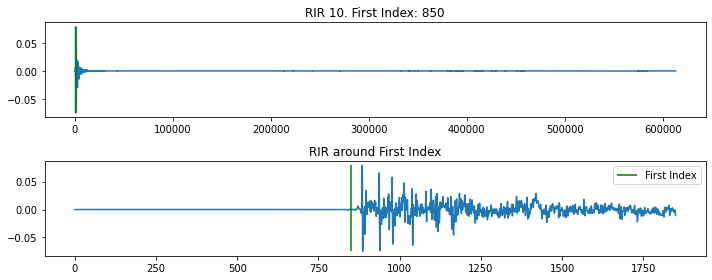

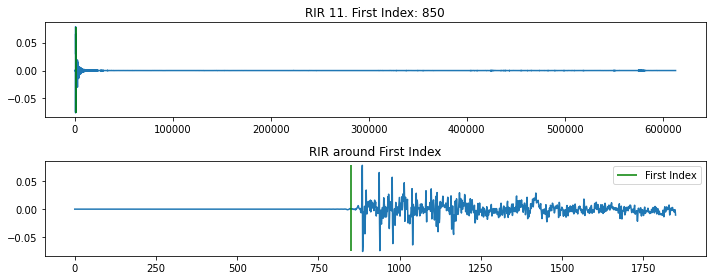

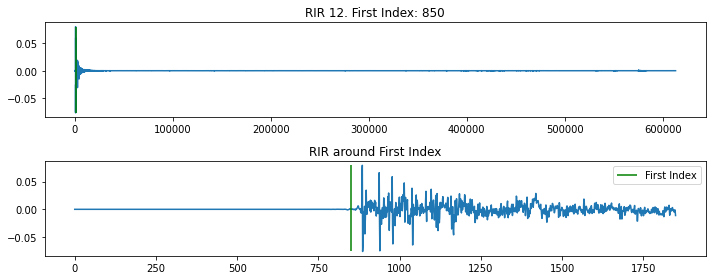

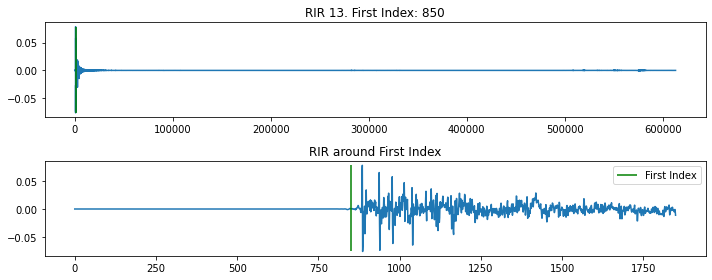

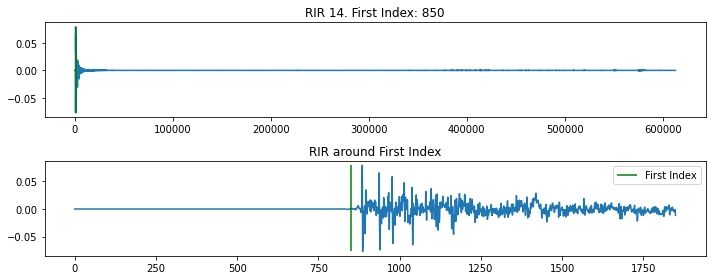

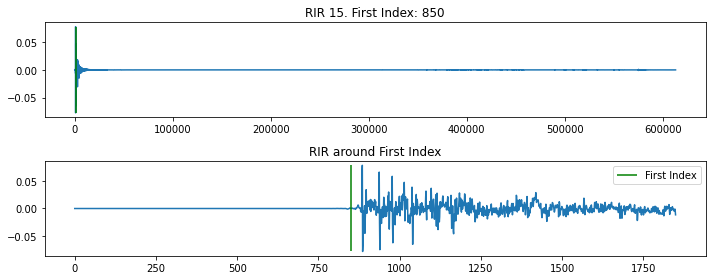

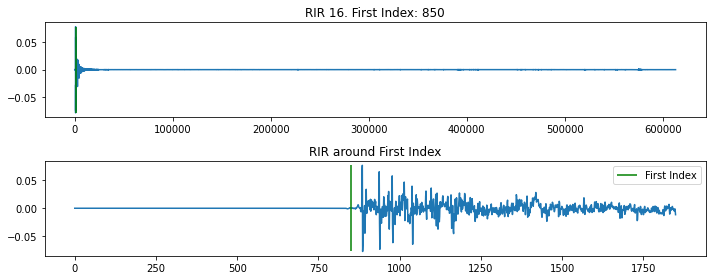

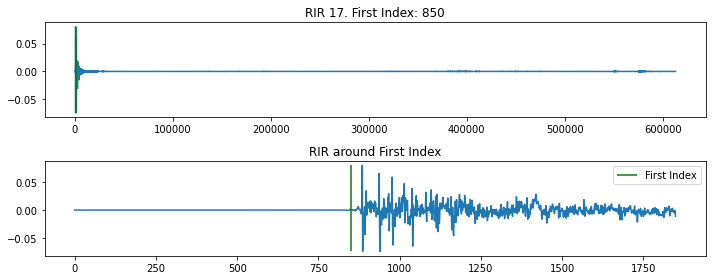

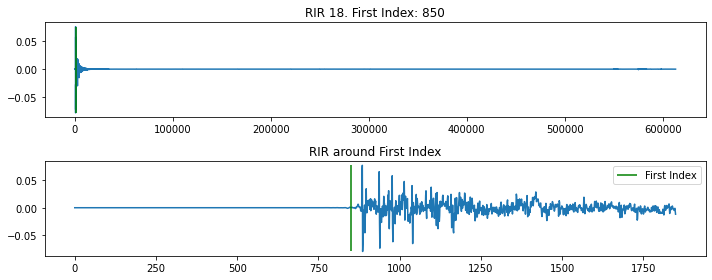

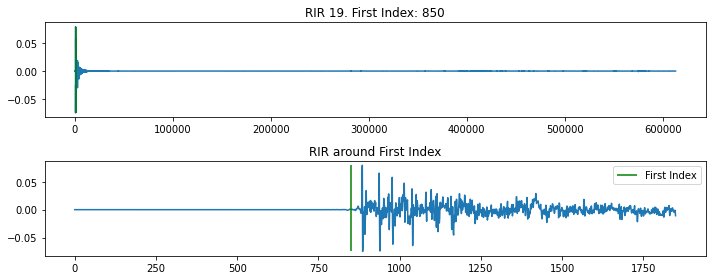

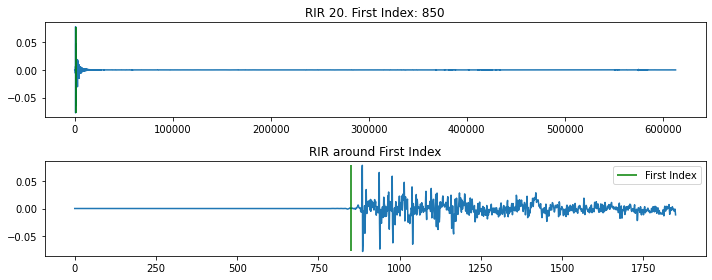

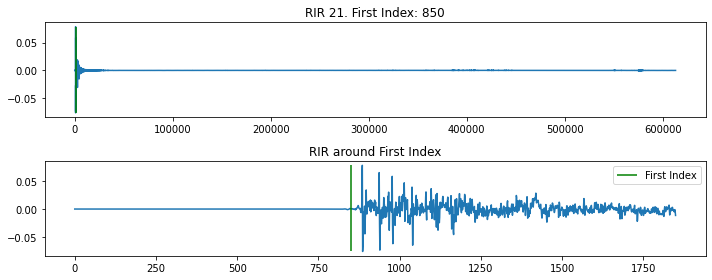

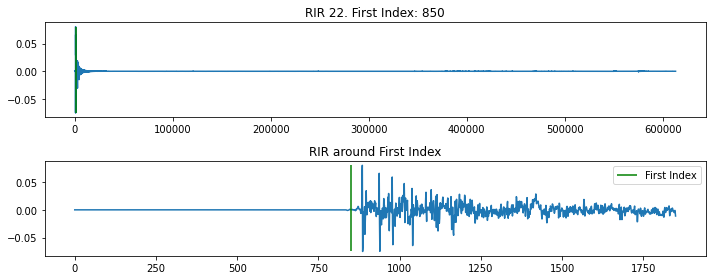

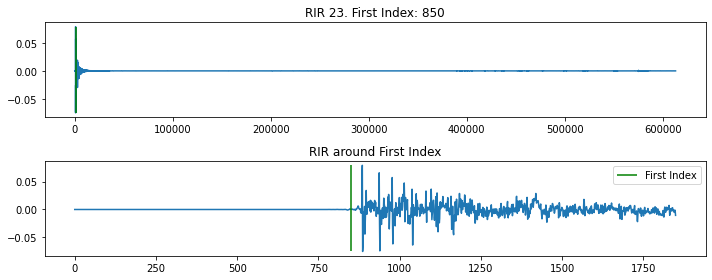

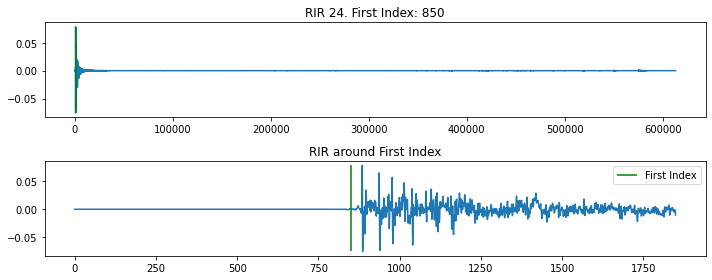

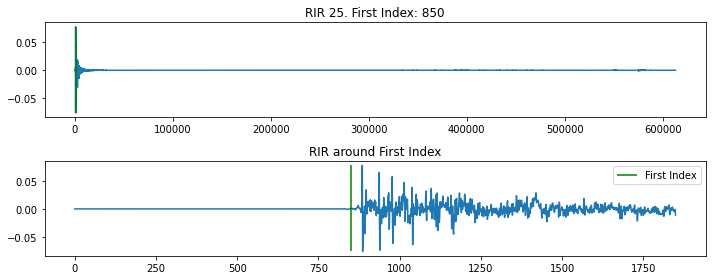

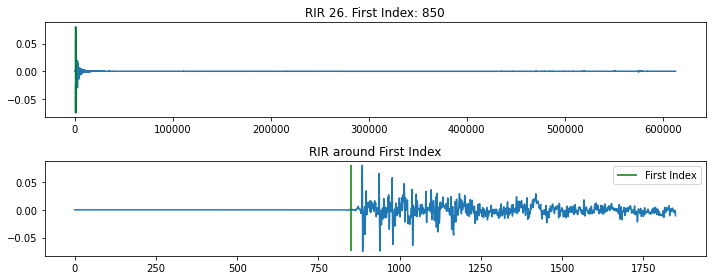

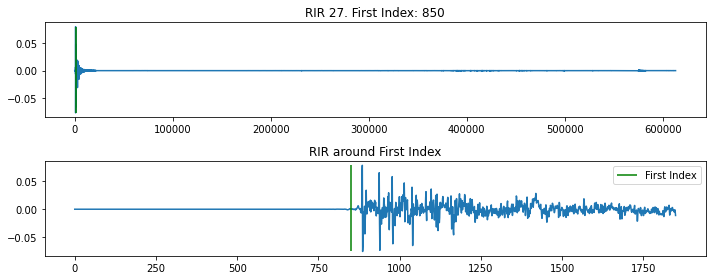

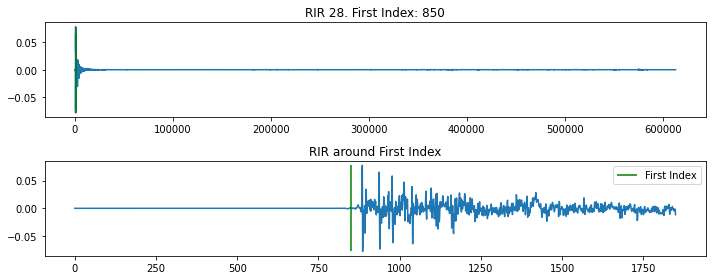

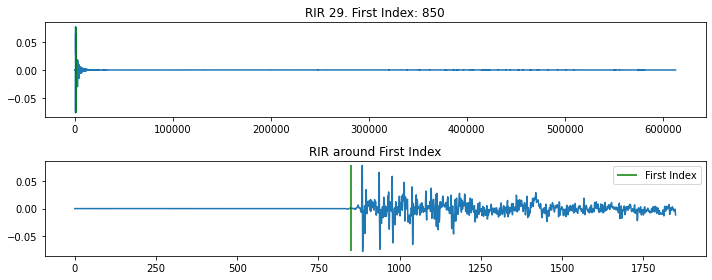

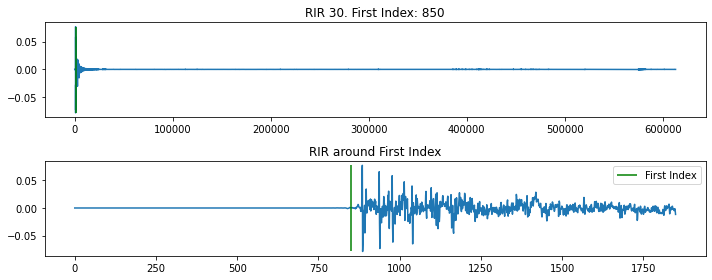

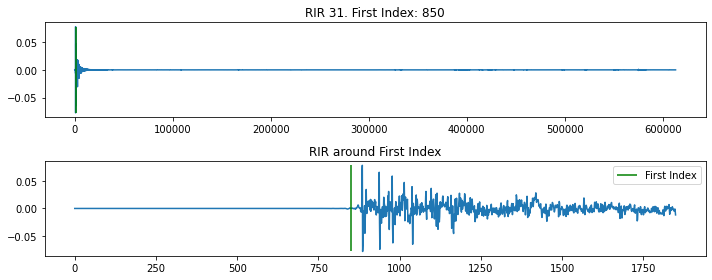

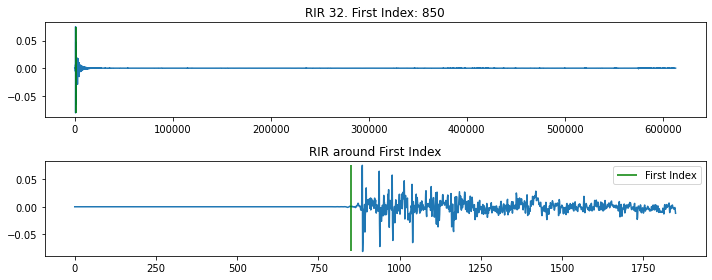

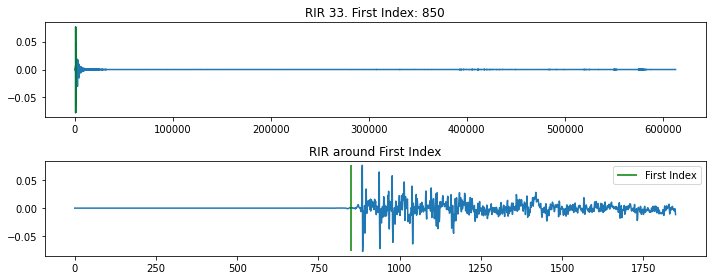

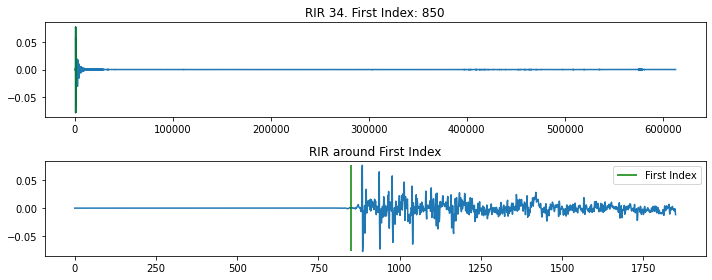

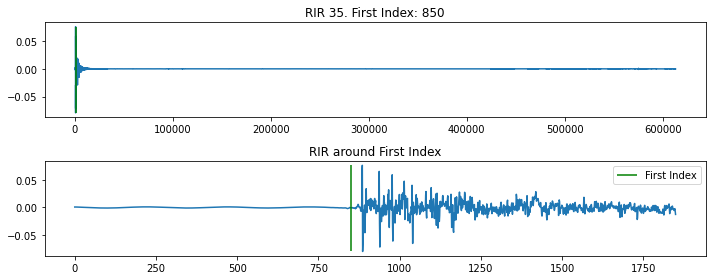

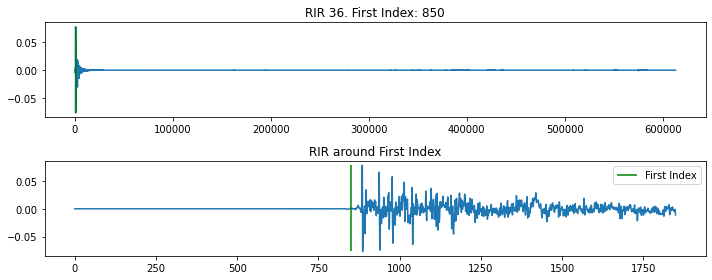

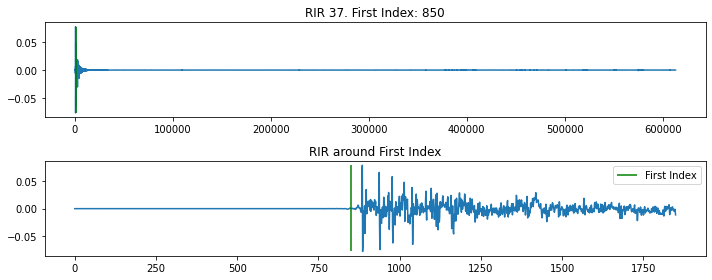

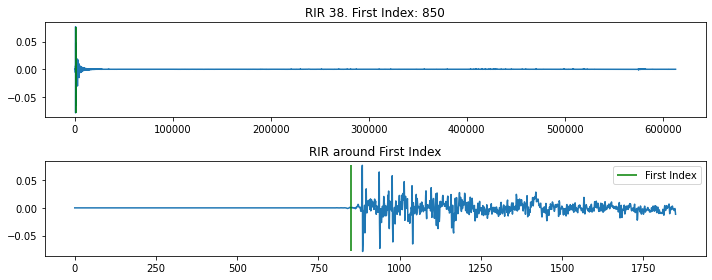

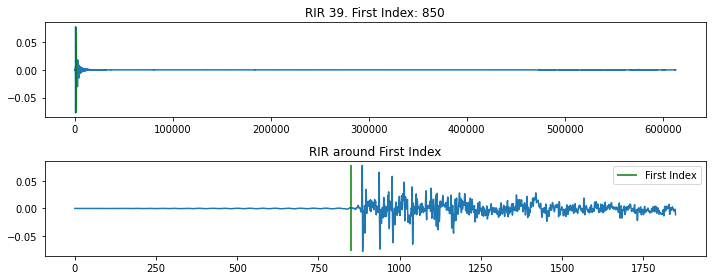

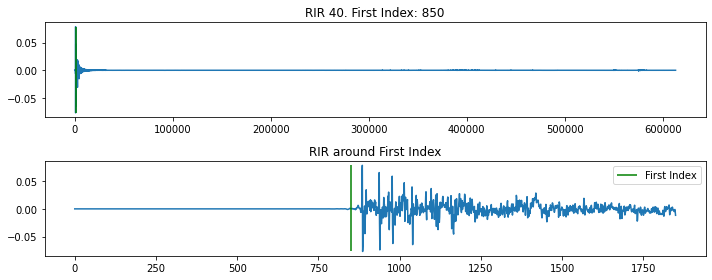

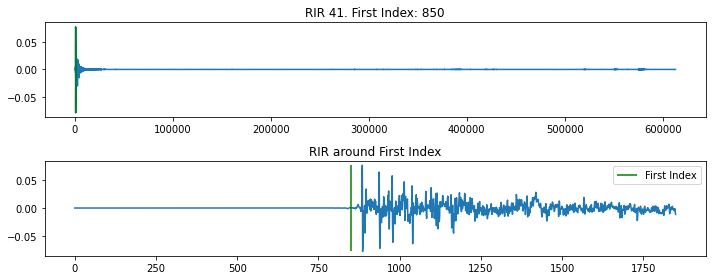

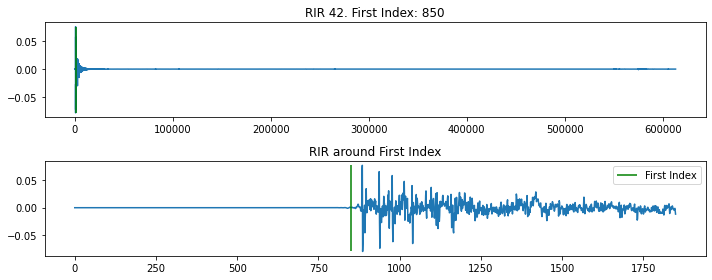

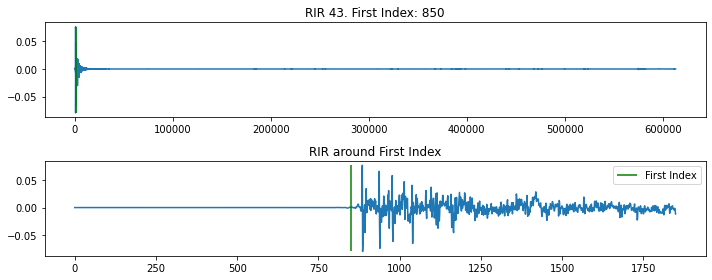

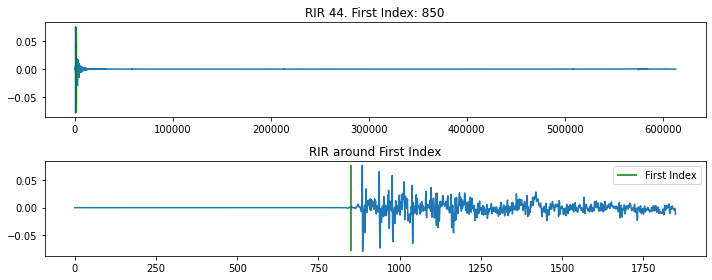

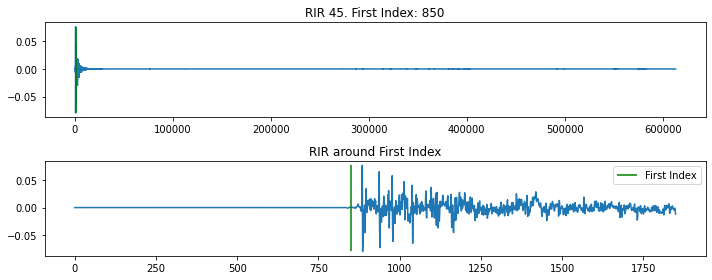

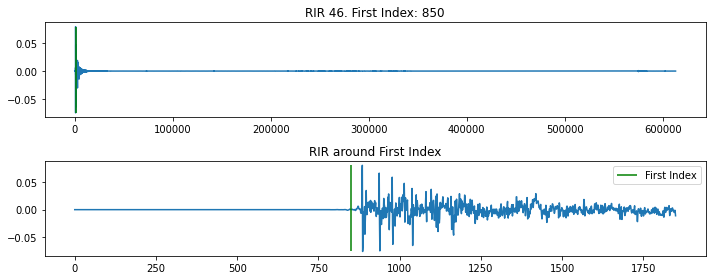

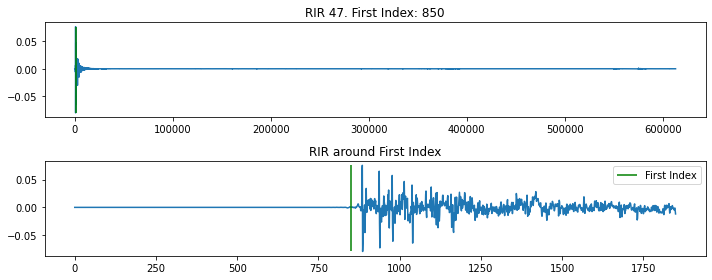

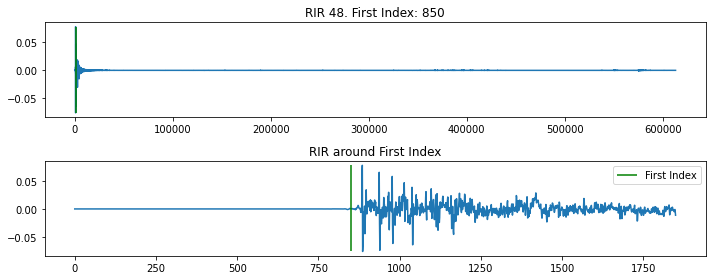

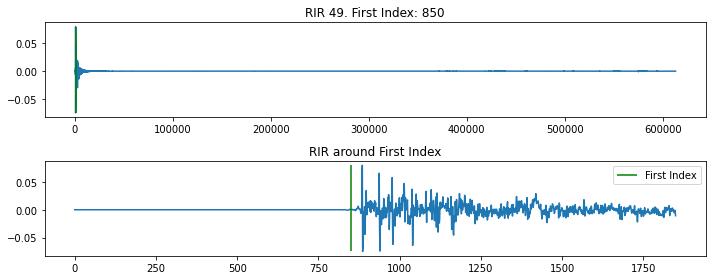

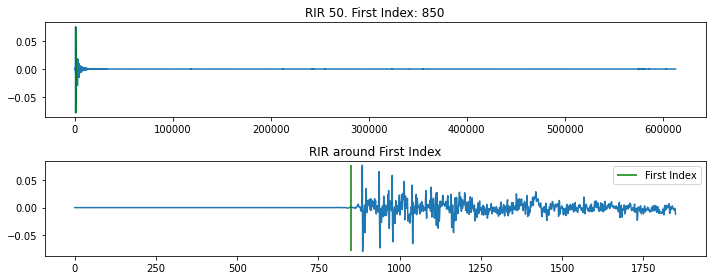

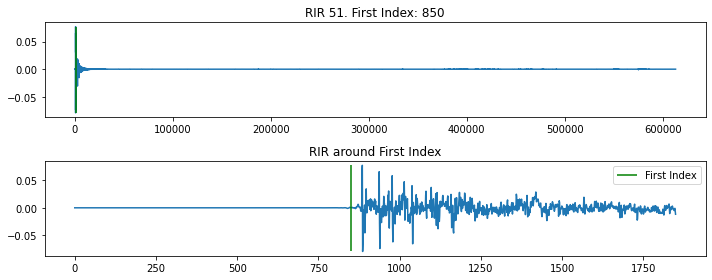

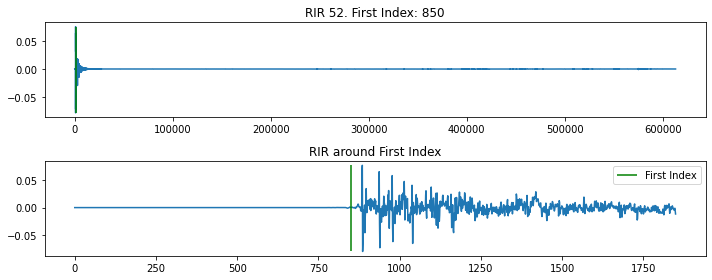

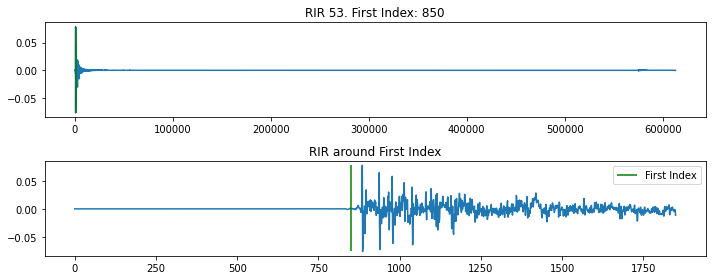

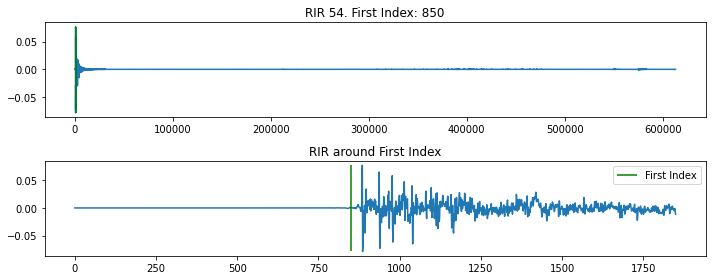

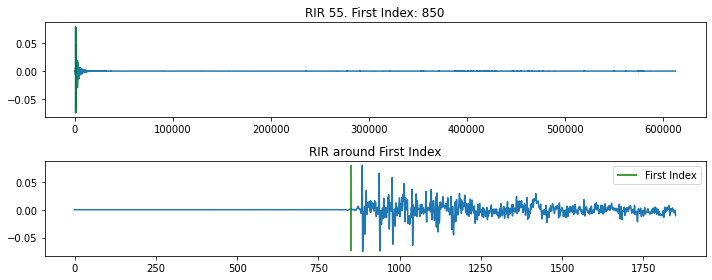

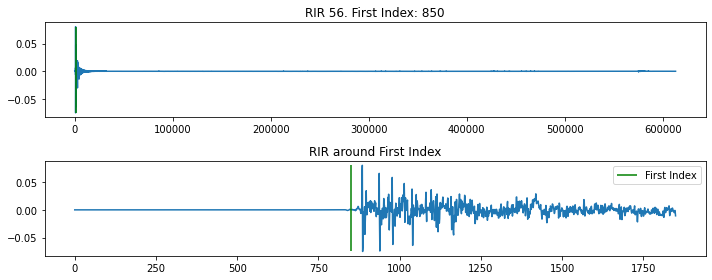

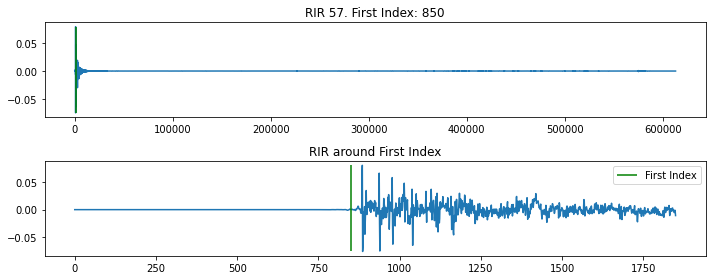

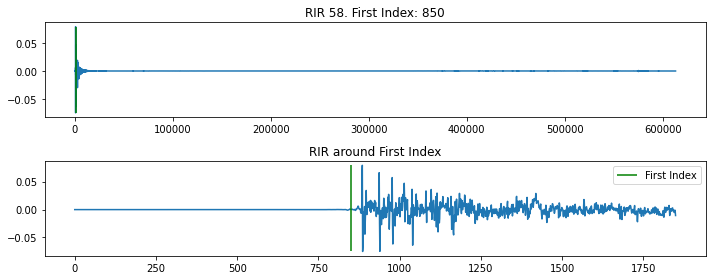

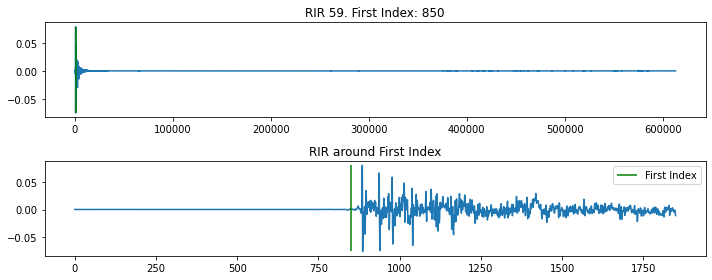

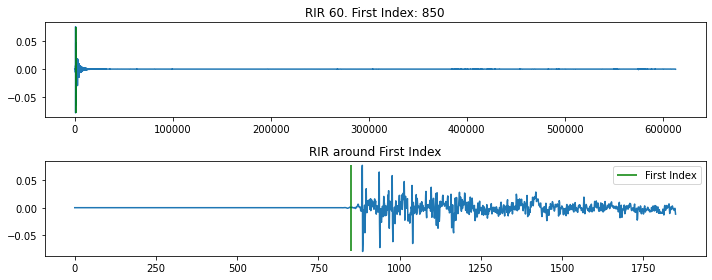

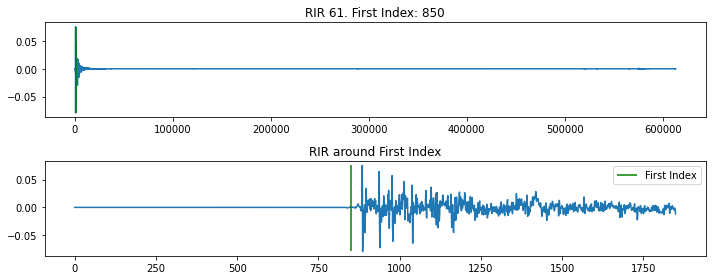

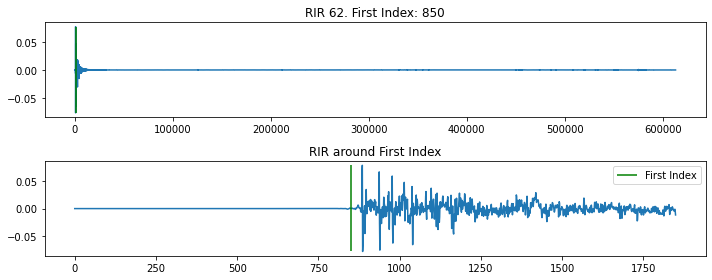

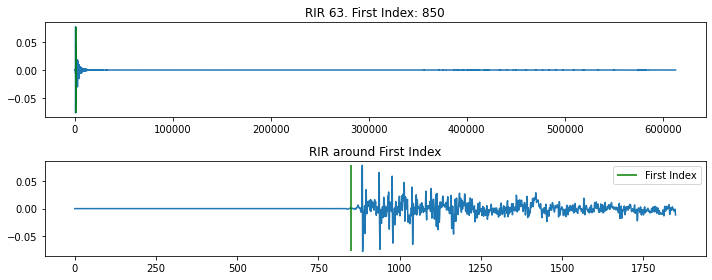

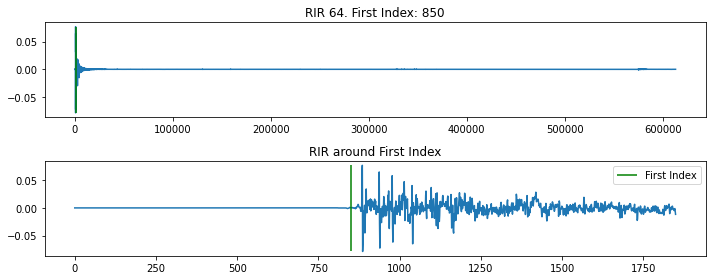

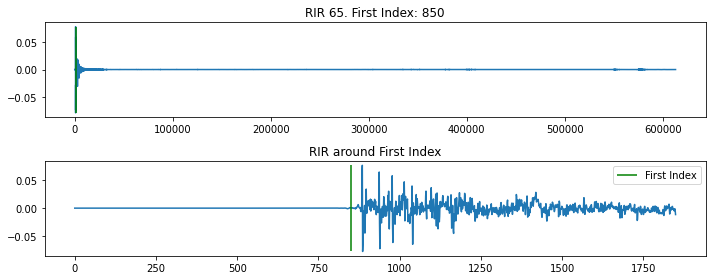

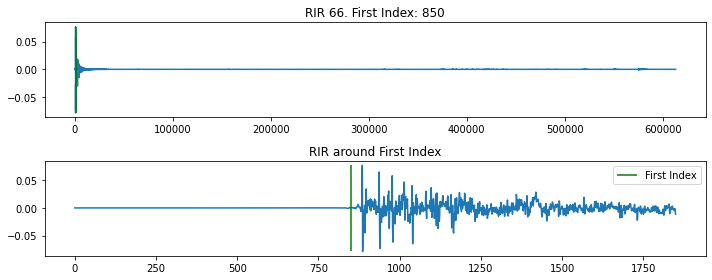

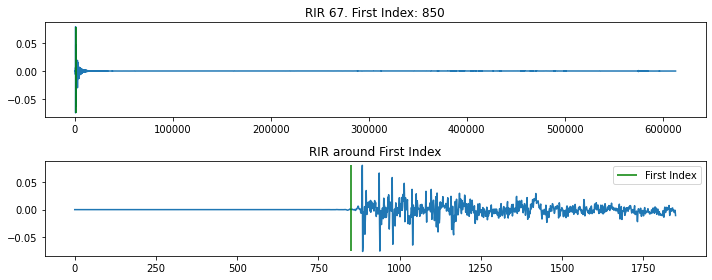

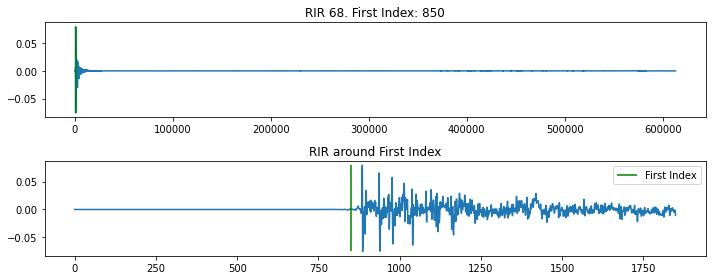

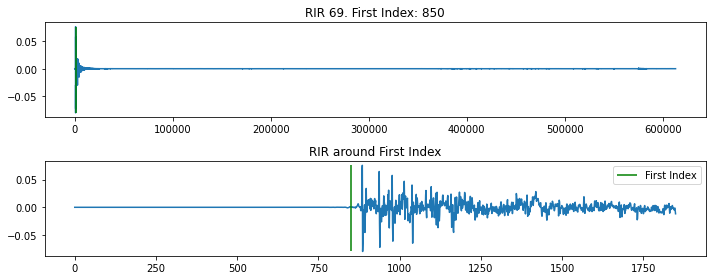

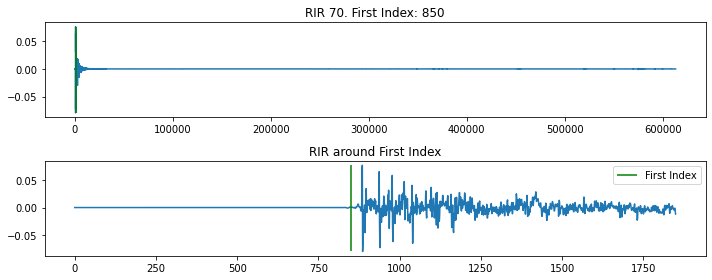

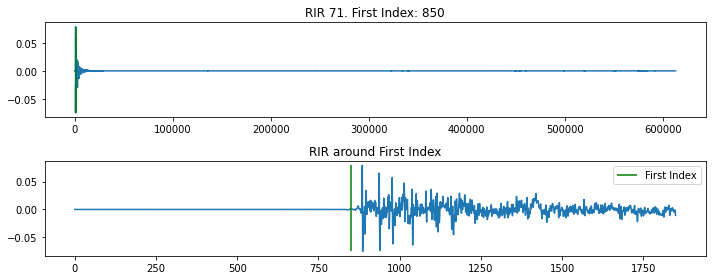

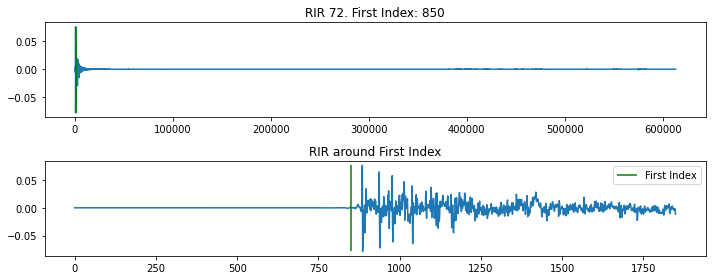

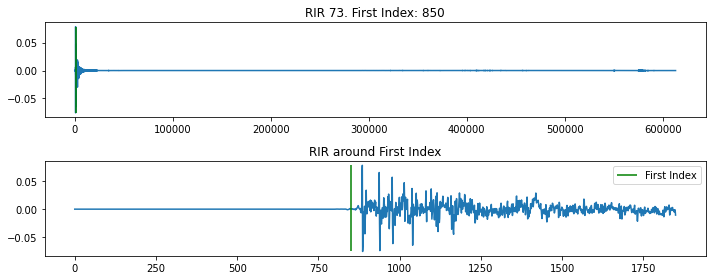

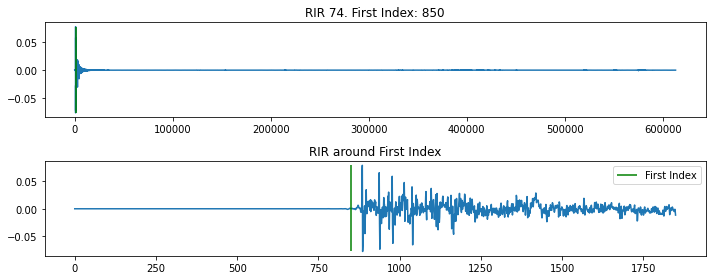

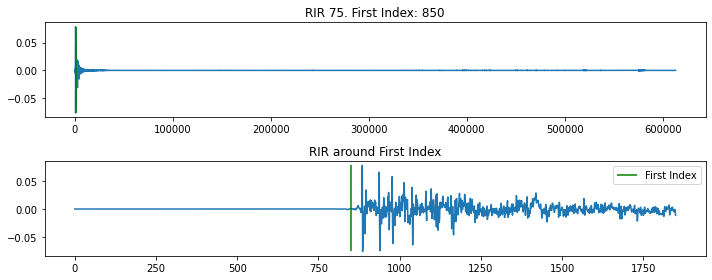

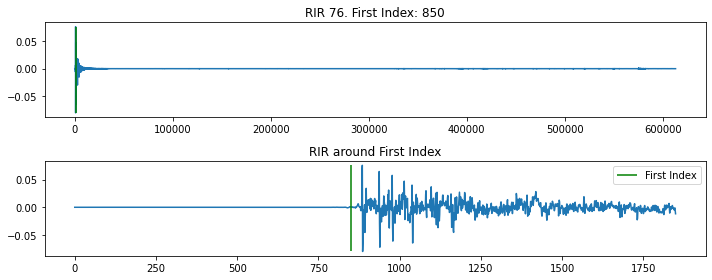

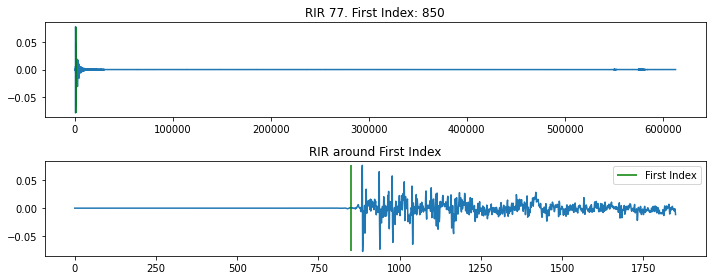

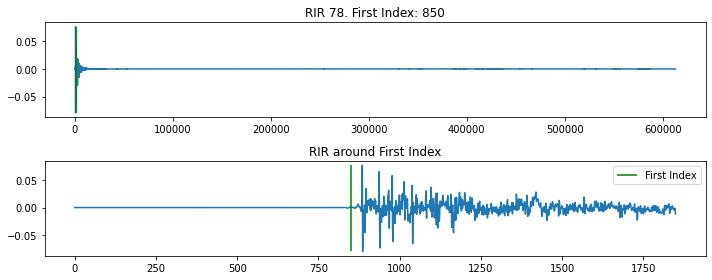

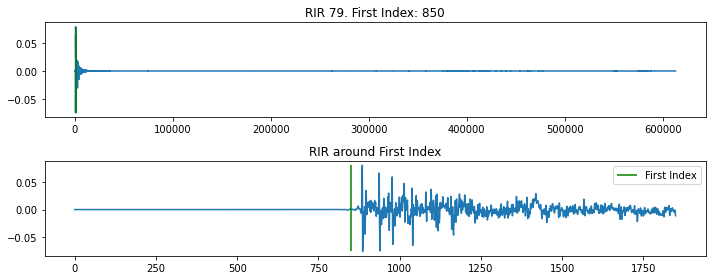

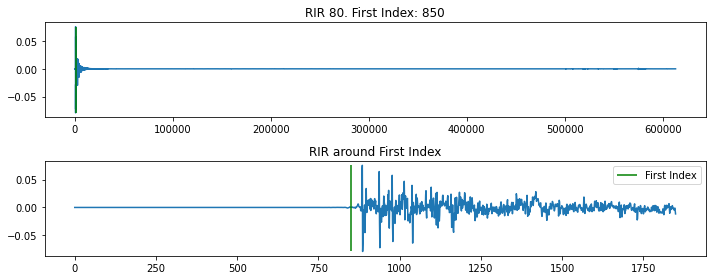

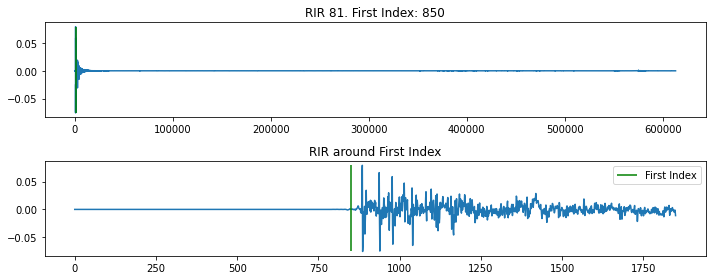

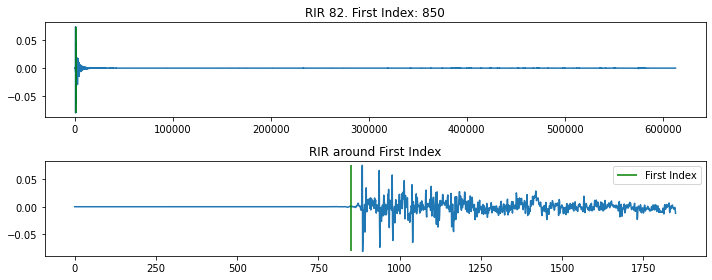

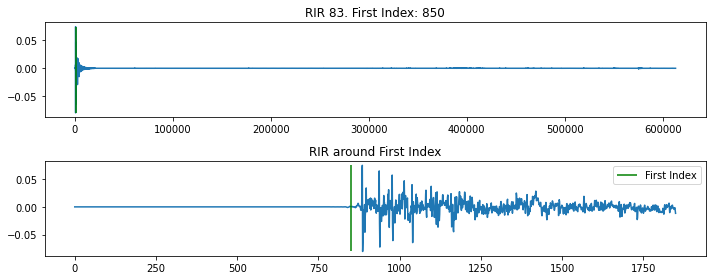

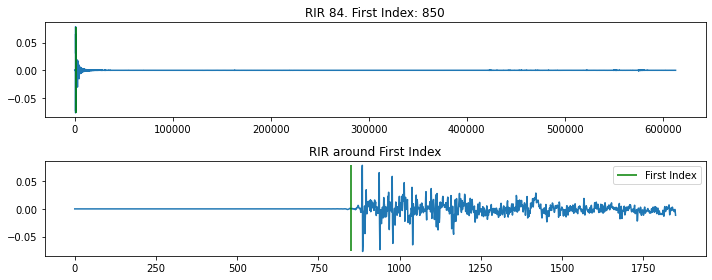

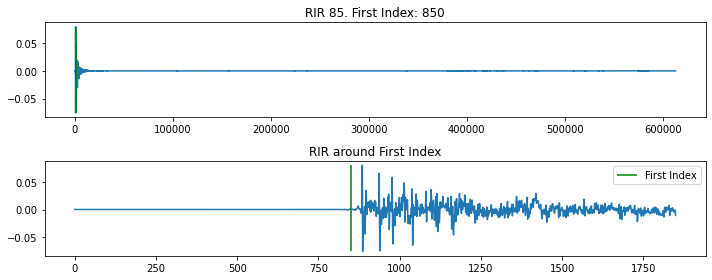

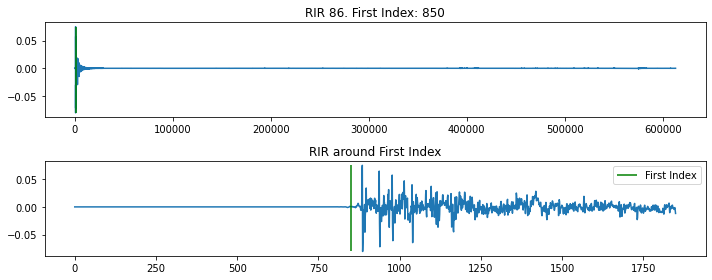

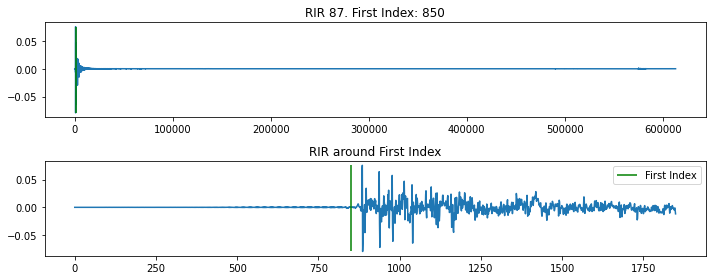

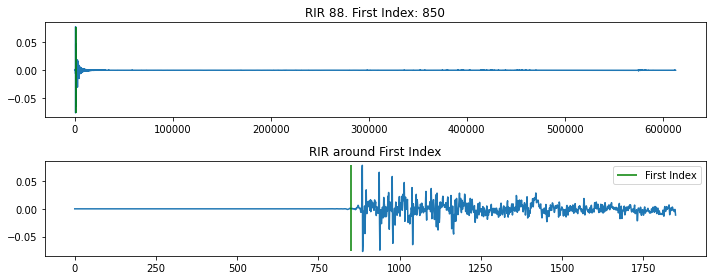

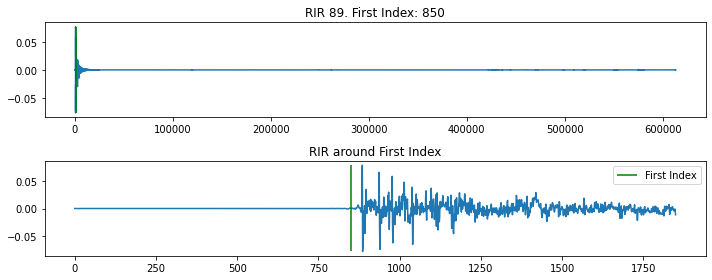

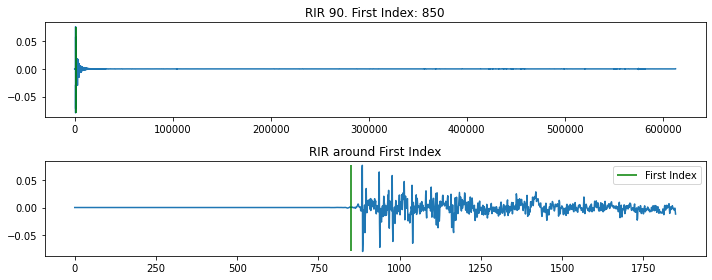

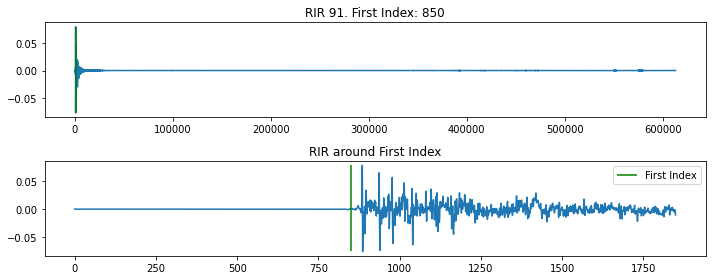

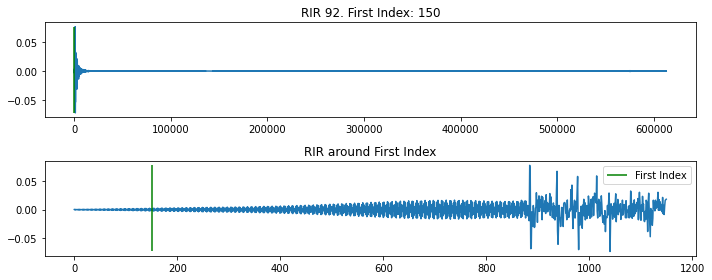

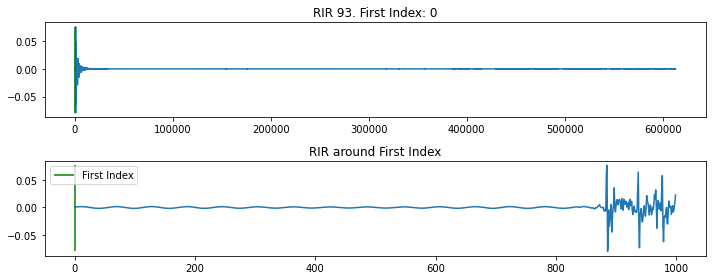

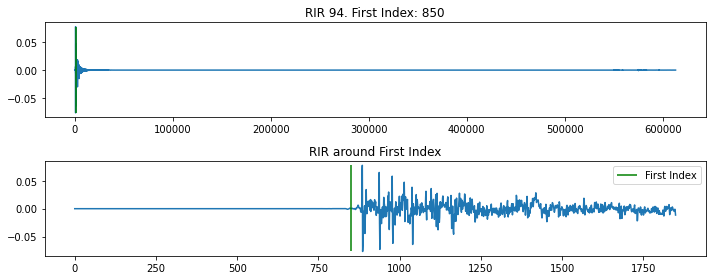

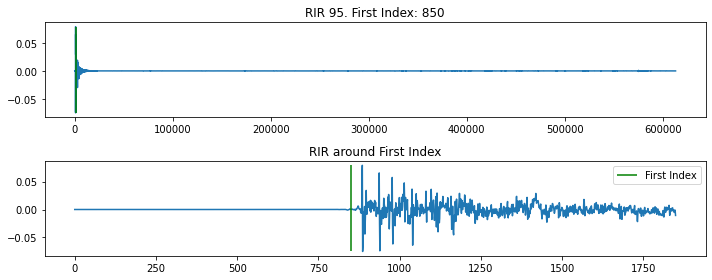

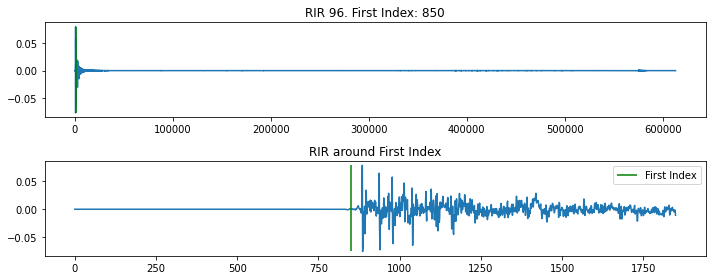

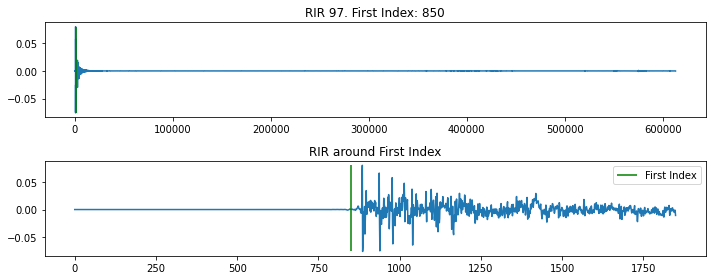

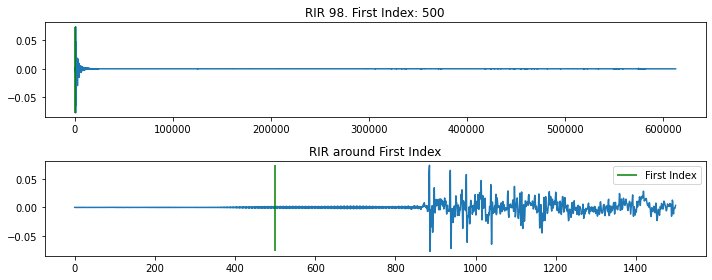

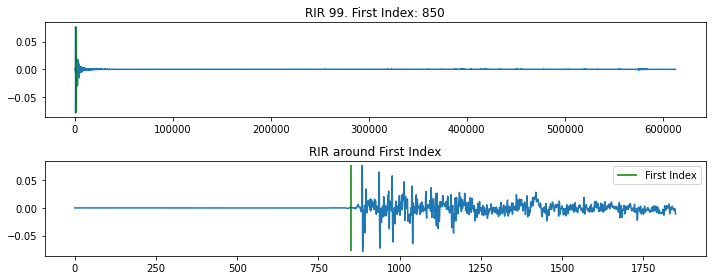

In [31]:
speech, speech_sr = sf.read(speech_path)

# See below that the direct path delay directly corresponds to first non-zero index of convolved speech,
# which is unrelated to room acoustics. It's just related to microphone's distance from source and speed of sound.
# # convolve the speech with the kernel
# conv_speech = signal.fftconvolve(speech, kernel.flatten(), mode='full')
# fig, axes = plt.subplots(2, 1, figsize=(10, 4))
# axes[0].plot(speech)
# axes[0].set_title("Speech")
# axes[0].set_xlim(0, 10000)
# axes[1].plot(conv_speech)
# axes[1].set_title("Convolved Speech")
# axes[1].set_xlim(0, 10000)
# plt.tight_layout()
# plt.show()
# plt.close(0)
# # we see that the convolved speech and raw speech are equal after the delay
# print(len(speech), len(conv_speech), len(conv_speech[tau:]))
# conv_speech = conv_speech[tau:]
# conv_speech = conv_speech[:len(speech)]
# print(np.allclose(conv_speech, speech))

# Now we explore some methods to estimate the direct path delay from the RIR and remove it.
for rir_num in range(100):
    mit_rir_path = soundcam_rirs[rir_num]
    # mit_rir_path = mit_rirs[rir_num]
    # mit_rir_path = homula_rirs[rir_num]

    if ".npy" in mit_rir_path:
        rir = np.load(mit_rir_path)[0,:]
        rir_sr = 48000 # this must be soundcam
    else:
        rir, rir_sr = sf.read(mit_rir_path)
    if len(rir.shape) > 1:
        rir = rir[:, 0]
    # upsample rir to same sample rate as speech
    rir = librosa.resample(rir,
        orig_sr=rir_sr,
        target_sr=speech_sr,
        res_type='soxr_hq')


    # find energy of each frame
    frame_size = 50  # Example frame size
    frame_energy = []
    for i in range(0, len(rir), frame_size):
        frame = rir[i:i+frame_size]
        energy = np.sum(frame**2)
        frame_energy.append(energy)
    sorted_frame_energy_is = np.argsort(frame_energy)

    # Option 1: Determine when "noise" prior to received speech stops
    # #find bottom 10% of frame energies - take those as noise frames
    # num_frames = len(frame_energy)
    # num_noise_frames = int(num_frames * 0.2)
    # noise_frame_indices = sorted_frame_energy_is[:num_noise_frames]

    # # compute noise as mean of the noise frames
    # noise_sections = []
    # for i, energy in enumerate(frame_energy):
    #     if i in noise_frame_indices:
    #         start = i * frame_size
    #         end = min((i+1) * frame_size, len(rir))
    #         noise_sections.append(rir[start:end])
    # noise_data = np.concatenate(noise_sections)
    # mean_noise = np.mean(noise_data)

    ## find the first frame that is not noise
    # first_index = 0
    # for i in range(len(frame_energy)):
    #     if i not in noise_frame_indices:
    #         first_index = i * frame_size
    #         break

    # Option 2: Find when real speech starts, defined as the first frame in some upper percentile of frame energies
    upper_percentile = np.percentile(frame_energy, 99)
    # find the first frame in the upper quintile
    first_index = 0
    for i in range(len(frame_energy)):
        if frame_energy[i] > upper_percentile:
            first_index = i * frame_size
            break
    
    # Option 3: Find when real speech starts, defining as the first frame in some upper percentile of sample values
    # upper_percentile = np.percentile(rir, 95)
    # first_index = 0
    # for i in range(len(rir)):
    #     if rir[i] > upper_percentile:
    #         first_index = i
    #         break


    fig, axes = plt.subplots(2, 1, figsize=(10, 4), tight_layout=True)
    axes[0].plot(rir)
    # axes[0].vlines(np.array(noise_frame_indices)*frame_size,  ymin = min(rir), ymax = max(rir), color='r', label='Noise Sections')
    axes[0].vlines(first_index, ymin = min(rir), ymax = max(rir), color='g', label='First Index')
    axes[0].set_title(f"RIR {rir_num}. First Index: {first_index}")
    axes[1].plot(rir[:first_index + 1000])
    axes[1].vlines(first_index, ymin = min(rir[:first_index + 1000]), ymax = max(rir[:first_index + 1000]), color='g', label='First Index')
    axes[1].set_title("RIR around First Index")
    plt.legend()
    plt.show()
    plt.close(0)


